## Multivariate Filtered Historical Simulation
We want to implement method for forecasting returns in a multivariate setting. The method applied is to model volatilities of the assets as univariate NGARCH processes while applying DCC (Dynamic Conditional Correlation) to model the time-varying correlations between them. See Peter Christoffersen, Value-at-Risk Models in Handbook of Financial Time Series (2009).

The benefit of using this method lies in simplifying the methodology for estimating and forecasting the correlation matrices. This is because we don't estimate every correlation. Instead we model covariance matrix (in some sense) as autoregressive process with only 2 parameters to be estimated.

We will apply the method to compute the VaR for a equally weighted portfolio with 2 assets - NVDA, AAPL

The procedure is explained along the lines. Most of the file consists of specifying the dynamics for univariate NGARCH models and DCC model together with their log-likelihoods. Briefly, we use univariate GARCH models to obtain standardized errors for returns. Then fit DCC model to covariance of those standardized errors. After fitting models, we transform errors so that they become uncorrelated using covariance matrix from DCC model at the same time. We then perform bootstrap to create a distribution of uncorrelated standardized errors fot time t+1. We then use forecasted DCC covariance matrix to obtain forecasted correlation structure between standardized errors. Finally each standardized errors are again multiplied by forecasted in univariate GARCH models standard deviations to ultimately obtain forecasted distribution of returns at t+1. We compute portfolio return distribution depending on our choice of weights which is used to compute VaR. Expected shortfall can also be added to this framework.

For all details regarding model specifications see Peter Christoffersen, Value-at-Risk Models in Handbook of Financial Time Series (2009)

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.linalg import cholesky

In [3]:
path = 'datasets/NVDA_AAPL_daily.xlsx'
data = pd.read_excel(path)
data.columns = ['Date', 'NVDA', 'AAPL']
dates = pd.to_datetime(data['Date'], format='%Y-%m-%d')
prices = np.array(data.drop(labels=['Date'], axis=1))

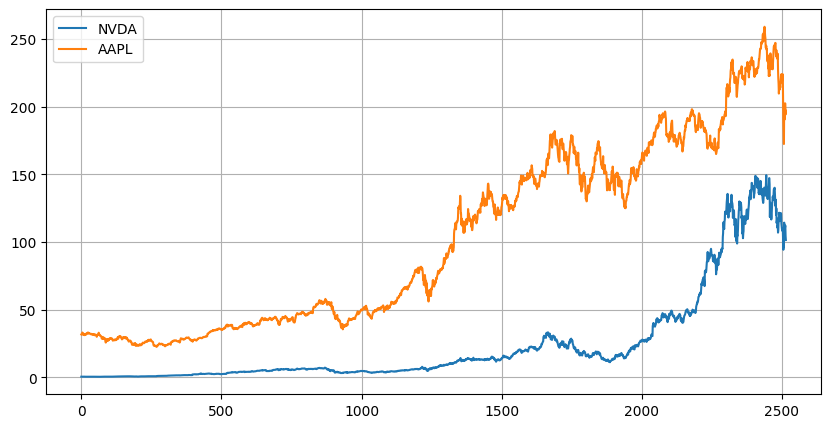

In [4]:
plt.figure(figsize=(10, 5))
plt.plot(prices, label=['NVDA', 'AAPL'])
plt.grid()
plt.legend()

In [5]:
# Compute returns
log_rets = np.diff(np.log(prices), axis=0)
print(log_rets.shape)

(2514, 2)


In [6]:
# Example portfolio weights - equally weighted portfolio:
W = np.array([0.5, 0.5])

Define first the univariate NGARCH model and its likelihood for optimization. (This is as in notebook (1).)

In [7]:
def sigma_sq_t_from_data_one_ahead(X, sigma_sq_uncon, kappa, alpha, theta):
    N = len(X)
    sigma_sq = np.zeros(N+1)
    sigma_sq[0] = sigma_sq_uncon
    for i in range(0, N):
        sigma_sq[i+1] = np.maximum(sigma_sq[i] + kappa * (sigma_sq_uncon - sigma_sq[i]) + alpha * (X[i]**2 - sigma_sq[i] - 2*theta*X[i]*np.sqrt(sigma_sq[i])), 1e-6)
    return sigma_sq

In [8]:
def neg_QMLE_GARCH11(params, x, sigma_sq_uncon):
    kappa, alpha, theta = params
    sigma_sq = sigma_sq_t_from_data_one_ahead(x, sigma_sq_uncon, kappa, alpha, theta)
    sigma_sq = sigma_sq[:-1]
    qmle = - 0.5 * np.sum(np.log(sigma_sq) + x**2 / sigma_sq)
    return -qmle

Now, define model for conditional correlation matrices.

1. Preparation - function to transform covariance matrix to correlation matrix. Then function to find nearest positive definite to a input matrix.

In [9]:
def cov_to_corr(matrix):
    # Make exactly symmetric:
    matrix = (matrix + matrix.T) / 2
    # Avoid negative values in sqrt
    d = np.sqrt(np.maximum(np.diag(matrix), 1e-8))
    # Create diagonal matrix with inverse standard deviations on the diagonal.
    d_mat = np.diag(1.0 / d)
    # Compute correlation matrix:
    corr_mat = d_mat @ matrix @ d_mat
    # Ensure the diagonal is exactly 1:
    np.fill_diagonal(corr_mat, 1.0)
    return corr_mat

In [10]:
def nearest_PD(A):
    """Find the nearest positive-definite matrix to A using Higham’s algorithm."""
    B = (A + A.T) / 2
    _, s, V = np.linalg.svd(B)
    H = V.T @ np.diag(s) @ V
    A2 = (B + H) / 2
    A3 = (A2 + A2.T) / 2

    # Test for positive definiteness
    try:
        np.linalg.cholesky(A3)
        return A3
    except np.linalg.LinAlgError:
        # If it’s still not PD, adjust with a small identity matrix
        spacing = np.spacing(np.linalg.norm(A))
        I = np.eye(A.shape[0])
        k = 1
        while True:
            try:
                np.linalg.cholesky(A3 + I * spacing * k)
                return A3 + I * spacing * k
            except np.linalg.LinAlgError:
                k += 1


2. Define correlation matrix dynamics

In [11]:
def DCC_corr_one_ahead(Z, Q_uncon, kappa, alpha):
    N, n_variables = Z.shape # Z - N x n_assets shocks over time
    Q = np.zeros(shape=(N+1, n_variables, n_variables)) # covariance matrices over time
    G = np.zeros_like(Q) # corresponding correlation matrices.
    Q[0] = Q_uncon.copy()
    G[0] = cov_to_corr(Q[0])

    for i in range(N):
        z_col = Z[i].reshape(-1, 1) # take shocks for assets at time i and make them column vector
        z_outer = np.dot(z_col, z_col.T)
        Q[i+1] = Q[i] + kappa * (Q[0] - Q[i]) + alpha * (z_outer - Q[i])
        G[i+1] = cov_to_corr(Q[i+1])

    return G

3. Define QMLE (Quasi-Maximum-Likelihood) for optimization.

In [12]:
def DCC_log_likelihood(params, Z, Q_uncon):
    kappa, alpha = params

    # Constraints:
    if kappa < 0.:
        return 1e10

    G = DCC_corr_one_ahead(Z, Q_uncon, kappa, alpha)
    G = G[:-1]

    log_lik = 0.
    for i, g in enumerate(G):
        g += np.eye(g.shape[0]) * 1e-6 # small constant to diagonal ensures positive definiteness
    # Compute log-determinants:
    sign, logdet = np.linalg.slogdet(g)
    if sign <= 0:
        return 1e10 # if determinant < 0 penalize

    z = Z[i].reshape(-1, 1)
    log_lik += logdet + z.T @ np.dot(np.linalg.inv(g), z)

    return 0.5 * log_lik

Finally we implement the FHS (Filtered Historical Simulation) method as follows:
1. Use the window of past observation to fit GARCH and DCC models.
2. Obtain uncorrelated shocks $Z^D$ for each time in the window. $Z_t^D = \Gamma^{-1/2}_t Z_t$, where $\Gamma$ is a DCC correlation matrix.
3. Draw M times from $Z^D$ (M times same day for all assets) 
4. M-times, compute random returns for the next day: $R_{t+1} = D_{t+1}\Gamma^{1/2}_{t+1} Z^D_{t+1}$ using the random draws from uncorrelated shocks, forecasted volatilites in $D_{t+1}$ and forecasted correlation matrix in $\Gamma_{t+1}$
5. Compute 'portfolio' return by multiplying returns with weights then compute VaR / ES in a standard way.

Note: in the code matrix $\Gamma$ is denoted as G 

In [69]:
def mFHS_var(X, W, window, alpha):
    N, n_variables = X.shape
    vars = []

    for i in range(N - window + 1):
        #print(i/N)
        X_wind = X[i: i + window]
        # Fit GARCH
        res_GARCH = []
        D = np.zeros(shape=(window+1, n_variables)) # store also volatilities for t+1
        Z = np.zeros(shape=(window, n_variables)) # shocks for next period will be sampled later
        
        for variable in range(n_variables):
            X_wind_variable = X_wind[:, variable]
            sigma_sq_uncon = np.var(X_wind_variable)
            init_0 = [0.01, 0.2, 0.5]
            bounds_0 = [[1e-6, 1.], [1e-6, 1.], [-1., 1.]]
            res_temp = minimize(neg_QMLE_GARCH11, x0=init_0, bounds=bounds_0, args=(X_wind_variable, sigma_sq_uncon)).x
            res_GARCH.append(res_temp)
            sigma_sq_variable = sigma_sq_t_from_data_one_ahead(X_wind_variable, sigma_sq_uncon, res_temp[0], res_temp[1], res_temp[2])
            D[:, variable] = sigma_sq_variable
            z_variable = X_wind_variable / np.sqrt(sigma_sq_variable[:-1])
            Z[:, variable] = z_variable
        # Fit DCC
        Q_unconditional = np.cov(Z.T)
        init_1 = [0.05, 0.4]
        bounds_1 = [[1e-6, 2.], [-1., 1.]]
        res_DCC = minimize(DCC_log_likelihood, x0=init_1, bounds=bounds_1, args=(Z, Q_unconditional, )).x

        # Obtain Correlation Matrices G:
        G = DCC_corr_one_ahead(Z, Q_unconditional, res_DCC[0], res_DCC[1])

        # Obtain uncorrelated shocks.
        Z_uncorr = np.zeros(shape=(window, n_variables))
        for j in range(window):
            G_temp = (G[j] + G[j].T) / 2 + np.eye(n_variables) * 1e-4
            G_pd = nearest_PD(G_temp)
            A = np.linalg.cholesky(G_pd)
            A_inv = np.linalg.inv(A)
            Z_uncorr[j, :] = np.matmul(A_inv, Z[j])

        # Sample M days (shocks for all assets from that day) to create distribution for day-ahead.
        M = 1000
        indices = np.random.choice(window, size=M, replace=True)
        Z_sample = Z[indices]

        # Compute returns for the next day:
        G_pd = nearest_PD(G[-1])
        A = np.linalg.cholesky(G_pd)
        Z_corr = Z_sample @ A
        R_next = Z_corr * np.sqrt(D[-1])

        # Compute portfolio returns by multiplying with weights:
        R_portfolio = np.dot(R_next, W)
        # Compute var forecast for the next day relative to the window:
        vars.append(np.quantile(R_portfolio, alpha, method='inverted_cdf'))

    return np.array(vars)

We apply the method to all observations. (Computation might take some time and alternatively only a period of time can be used e.g. log_rets[$-1000:$])

In [ ]:
log_rets_period = log_rets
window = 252
alpha = 0.01
v = mFHS_var(log_rets_period, W, window, alpha)

In [64]:
# The procedure migh sometimes result with numerical problems causing VaR to be large. For the purpose of presentation in those (very few) cases fill VaR outliers with VaR from previous day.
for i, value in enumerate(v):
    if value < -0.2:
        v[i] = v[i-1]

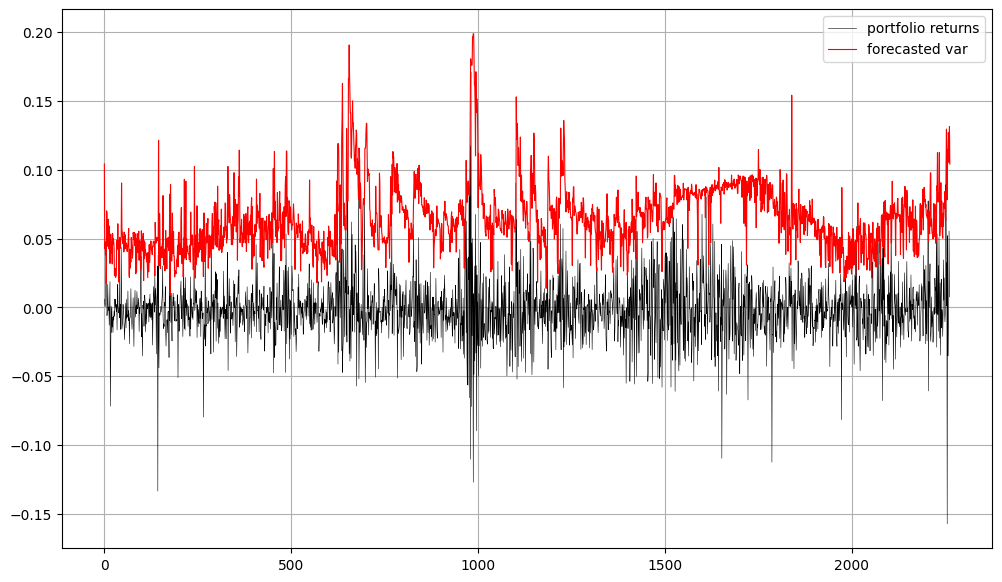

In [67]:
portfolio_returns = np.dot(log_rets_period[window:], W)
plt.figure(figsize=(12, 7))
plt.plot(-portfolio_returns, label='portfolio returns', lw=0.4, c='black')
plt.plot(-v, label='forecasted var', c='red', lw=0.8)
plt.grid()
plt.legend()

See how often VaR has been exceeded.

In [68]:
print('Fraction of VaR exceedences: ', np.mean(np.where(-v[:-1] < portfolio_returns, 1, 0)))
print('Forecasted VaR for next day: ', -v[-1])

Fraction of VaR exceedences:  0.01237842617152962
Forecasted VaR for next day:  0.10411625189227716


# Conclusions
The computed VaR using this method appears reflects autocorrelations in both individual assets volatility but also their covariances. Matrix inverses and Cholesky decompositions may cause numerical issues or require special adjustments. One loop of the procedure is relatively fast however some computational cost can arise during backtesting when number of periods is large.